In [1]:
# 导入库
import pandas as pd
import matplotlib.pyplot as plt
import portfolio_construction_functions as pc

In [2]:
# 导入情感数据
path_Reuter = '../Data/Sentiment_Scores/Merged Sentiment Reuters.csv'
path_MW = '../Data/Sentiment_Scores/Merged Sentiment MW.csv'
path_CNN = '../Data/Sentiment_Scores/Merged Sentiment CNN.csv'

df_Reuters_sentiment = pd.read_csv(path_Reuter)
df_MW_sentiment = pd.read_csv(path_MW)
df_CNN_sentiment = pd.read_csv(path_CNN)

# 拼接两个网站的情感分数
df_sentiment = [df_MW_sentiment, df_Reuters_sentiment, df_CNN_sentiment]
# df_sentiment = [df_MW_sentiment]
# df_sentiment = [df_Reuters_sentiment]
df_sentiment = pd.concat(df_sentiment)
df_sentiment = df_sentiment.groupby(['Date', 'Country']).mean(numeric_only=True).reset_index()

# 修改列名
df_sentiment = df_sentiment.rename(columns={
    'LMD_Polarity': 'LMD',
    'HIV4_Polarity': 'HIV4',
    'Vader_Polarity': 'Vader',
    'FinBert_Polarity': 'FinBert'
})

# 展示数据
df_sentiment.head()

,Date,Country,Unnamed: 0,LMD,HIV4,Vader,FinBert,Unnamed: 0.1
0,2012-01-01,Australia,0.0,NaN,NaN,NaN,NaN,0.0
1,2012-01-01,Canada,4199.0,NaN,NaN,NaN,NaN,1.0
2,2012-01-01,China,8398.0,-0.672303,0.345811,-0.3644,-0.322688,2.0
3,2012-01-01,Denmark,12597.0,NaN,NaN,NaN,NaN,3.0
4,2012-01-01,Finland,16796.0,NaN,NaN,NaN,NaN,4.0


In [3]:
# 导入收益率数据
df_return = pd.read_csv('../Data/daily_return.csv')

# 展示数据
df_return.head()

# # 展示为0或者NA的数据的数量
# print('Number of 0 or NA in each column:')
# print(df_return.isin([0, np.nan]).sum())


,Date,New Zealand,United Kingdom,Finland,Norway,United States,Sweden,Korea,Japan,Canada,...,Australia,Germany,France,China,Switzerland,Spain,Denmark,Italy,Singapore,Portugal
0,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-02,-0.010866,-0.207038,0.302897,0.235483,0.489692,0.154354,0.094609,-0.042270,0.178307,...,0.053087,0.393824,-1.345329,0.328191,0.241278,0.536400,0.065521,-0.189497,-0.251753,0.148492
2,2011-12-05,0.077141,-0.460678,-0.474224,-0.158909,-0.084015,-0.179613,0.056292,0.165816,0.227525,...,0.302855,-0.615728,1.099039,0.264403,-0.125720,3.778843,-1.723893,5.259712,-0.012405,3.308727
3,2011-12-06,0.201784,0.810078,0.100602,-0.190226,-0.406179,0.198203,-0.004941,0.066255,-0.330724,...,0.354603,0.150150,-0.863361,-0.157734,0.335027,-0.630513,0.272330,0.715348,0.047384,1.062182
4,2011-12-07,0.187048,0.129148,0.496636,0.290407,0.543003,0.567308,-0.043160,0.002849,0.596567,...,-0.273399,0.762903,0.199724,0.001528,0.198283,-1.476326,-0.028845,-0.948723,-0.251362,1.737582


In [4]:
# 转换日期格式
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], format='%Y-%m-%d')
df_return['Date'] = pd.to_datetime(df_return['Date'], format='%Y-%m-%d')

# 生成日期范围
all_dates = pd.date_range(start='2016-01-01', end='2022-12-31').tolist()
df_return = df_return[df_return['Date'].isin(all_dates)]
df_sentiment = df_sentiment[df_sentiment['Date'].isin(all_dates)]

# 去掉无用的列
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0'])
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0.1'])


# 过滤掉周末的情感数据
df_sentiment = df_sentiment[df_sentiment['Date'].dt.dayofweek < 5]


# 填充NA为0
df_sentiment = df_sentiment.fillna(0)

# Calculate the average sentiment for each country
average_polarity = df_sentiment[['LMD', 'HIV4', 'Vader', 'FinBert']].mean(axis=1)

# Create a new DataFrame to store the results
df_sentiment_aver = pd.DataFrame({
    'Date': df_sentiment['Date'],
    'Country': df_sentiment['Country'],
    'Average': average_polarity
})

# Rank the average sentiment for each day
df_sentiment_aver['Average_Rank'] = df_sentiment_aver.groupby('Date')['Average'].rank(ascending=False, method='first')


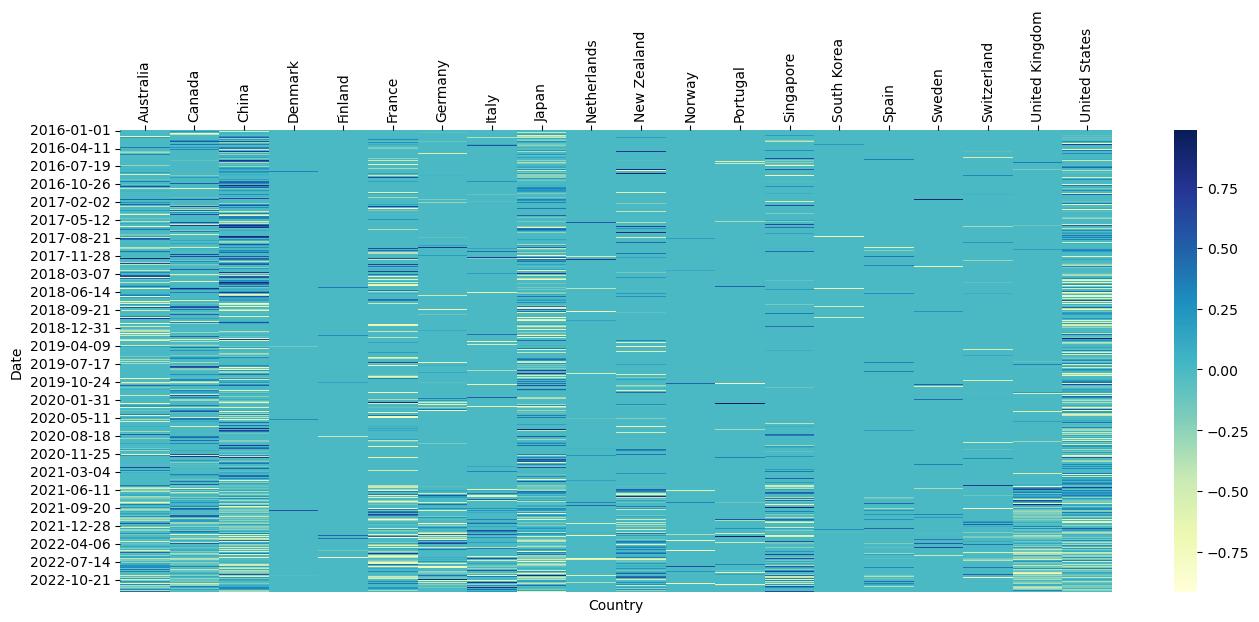

In [5]:
# 展示数据的Heatmap图, 颜色越深代表情感分数越高, 也就是越值得投资
pc.plot_sentiment_heatmap(df_sentiment_aver, '../Data/Images/Heatmap.png')
plt.show()

In [6]:
# 将Average_Polarity和Return赋给merged_data
merged_data = pd.merge(df_sentiment_aver, df_sentiment, on=['Date', 'Country'], how='outer')
df_return_melted = df_return.melt(id_vars='Date', var_name='Country', value_name='Return')
merged_data = pd.merge(merged_data, df_return_melted, on=['Date', 'Country'], how='outer')
column_order = ['Date', 'Country', 'LMD', 'HIV4', 'Vader', 'FinBert', 'Average', 'Return']
merged_data = merged_data[column_order]

merged_data

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
0,2016-01-01,Australia,0.0,0.0,0.0,0.0,0.0,0.012079
1,2016-01-01,Canada,0.0,0.0,0.0,0.0,0.0,0.003814
2,2016-01-01,China,0.0,0.0,0.0,0.0,0.0,0.007740
3,2016-01-01,Denmark,0.0,0.0,0.0,0.0,0.0,0.002515
4,2016-01-01,Finland,0.0,0.0,0.0,0.0,0.0,0.002510
...,...,...,...,...,...,...,...,...
38341,2022-12-26,Korea,NaN,NaN,NaN,NaN,NaN,-0.663004
38342,2022-12-27,Korea,NaN,NaN,NaN,NaN,NaN,0.253145
38343,2022-12-28,Korea,NaN,NaN,NaN,NaN,NaN,-0.524433
38344,2022-12-29,Korea,NaN,NaN,NaN,NaN,NaN,-0.515474


In [7]:
merged_data = merged_data.dropna(subset=['Return'])

## Correlation And Accuracy

In [8]:
correlations_result = pc.check_correlation(merged_data, 'Return')
print(correlations_result)

     Method  Correlation with Return
23      LMD                 0.003253
25     HIV4                -0.000352
27  FinBert                -0.006622
28  Average                -0.007528
31    Vader                -0.011441


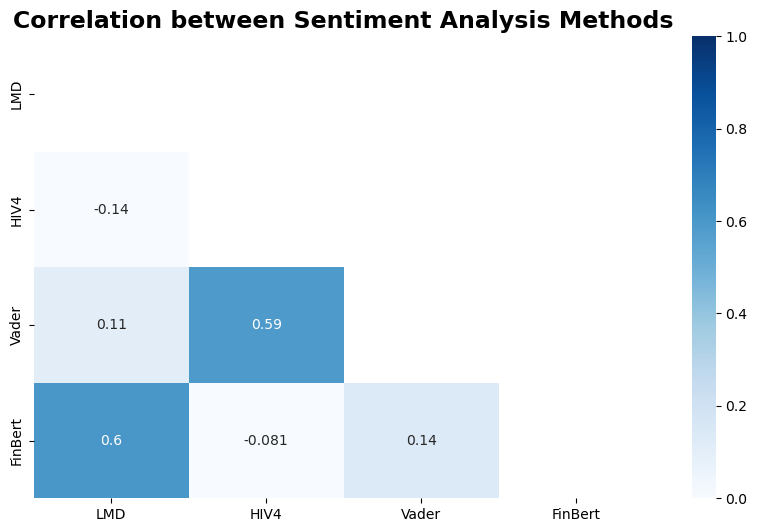

In [9]:
pc.plot_correlation_heatmap(merged_data, columns=['LMD','HIV4','Vader', 'FinBert'], title="Correlation between Sentiment Analysis Methods")
plt.show()

In [10]:
# 使用不同的策略计算收益率
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
dict_ret = pc.compute_strategy_performance(merged_data, strategies, all_dates)

new_portfolio_25 = pd.DataFrame(dict_ret).transpose()
new_portfolio_25 = new_portfolio_25.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'Vader', 3: 'FinBert', 4: 'Average'})
new_portfolio_25.reset_index(inplace=True)
new_portfolio_25.rename(columns={'index': 'Date'}, inplace=True)

# new_portfolio_25.to_csv('../Data/25_percent_portfolio.csv')

In [11]:
new_portfolio_25

,Date,LMD,HIV4,Vader,FinBert,Average
0,2016-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-01-04,0.170327,-0.170327,-0.170327,-0.170327,-0.170327
4,2016-01-05,0.150387,0.079262,0.079262,0.179987,0.179375
...,...,...,...,...,...,...
2552,2022-12-27,-0.119972,0.235304,0.109152,0.023232,0.006662
2553,2022-12-28,-0.064699,-0.168618,-0.083939,0.289729,-0.461638
2554,2022-12-29,0.133007,-0.021413,-0.248805,-0.254389,-0.277609
2555,2022-12-30,-0.588568,1.067939,0.761217,-0.588568,-0.588568


### IR of Long-Short Portfolio

In [12]:
IR_values = pc.compute_information_ratio(new_portfolio_25, strategies)
print(IR_values)

{'LMD': -0.01637453882716003, 'HIV4': -0.005311705225300196, 'Vader': -0.010086299730846677, 'FinBert': -0.006577214506165138, 'Average': -0.010229500156397802}


In [13]:
# 计算年化收益率
annualized_ret = pc.compute_annualized_return(new_portfolio_25, strategies)
print(annualized_ret)

{'LMD': nan, 'HIV4': nan, 'Vader': nan, 'FinBert': nan, 'Average': nan}


D:\Postgraduate\ContextualSentimentInvestmentTool\Part 4 PortfolioConstruction\portfolio_construction_functions.py:194: RuntimeWarning: invalid value encountered in scalar power
  annualized_ret = (1 + total_return) ** (252 / total_days) - 1


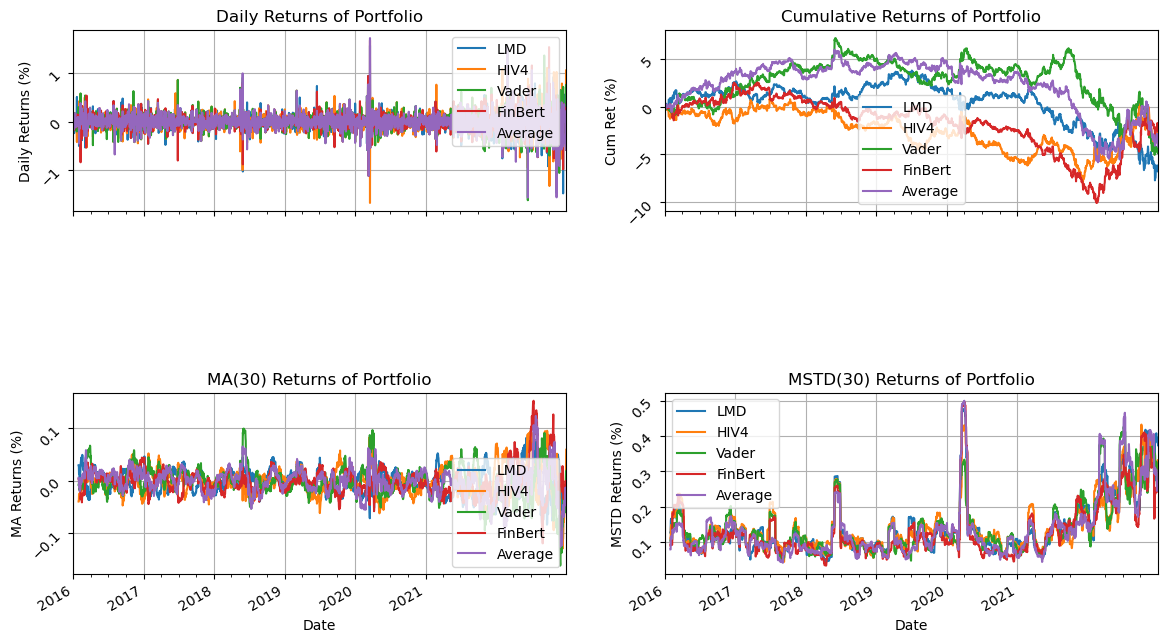

In [16]:
pc.plot_portfolio_summary(new_portfolio_25, start_date='2016-01-01', end_date='2022-12-31')
plt.show()